In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import igraph as ig
from collections import Counter
import pickle
import math

from src import acgraph as acg
from src import bcloader as bcl
from src import utils as ut
from src import bcgraph as bcg

### Load access control graph

In [2]:
rel_attnames = [
#'MGR_ID',
#'ROLE_ROLLUP_1',
'ROLE_ROLLUP_2',
'ROLE_DEPTNAME',
'ROLE_TITLE',
'ROLE_FAMILY_DESC',
'ROLE_FAMILY']
gur = acg.load_azkag_graph(rel_attnames=rel_attnames, isWeighted=True)
print('---Control Access Graph---')
print('Total edges:', len(gur.es))
print('Total vertices:', len(gur.vs))

gur_usrlabels,gur_reslabels = acg.get_labels(gur, byweights=False)
print('Num users:',len(gur_usrlabels))
print('Num resources:', len(gur_reslabels))

---Control Access Graph---
Total edges: 30872
Total vertices: 16524
Num users: 9298
Num resources: 7226


In [3]:
maxcc_gur = acg.get_largestcc(gur)
print('---Largest Connected Component---')
print('Total edges:', len(maxcc_gur.es))
print('Total vertices:', len(maxcc_gur.vs))

maxcc_usrlabels,maxcc_reslabels = acg.get_labels(maxcc_gur, byweights=False)
print('Num users:',len(maxcc_usrlabels))
print('Num resources:', len(maxcc_reslabels))

---Largest Connected Component---
Total edges: 30425
Total vertices: 15773
Num users: 8933
Num resources: 6840


### Load bicliques

In [4]:
#--Reload bicliques---
#bcs = bcl.load_bicliques('bcfinder_bicliques/maxcc_azkag_1_1_500_500.bi', maxcc_gur, rel_attnames, k=(1,1), l=1)
#with open('data_structures/maxcc_azkag_bcs_v2.pkl', 'wb') as f:
#    pickle.dump(bcs, f)

In [5]:
with open('data_structures/maxcc_azkag_bcs_v2.pkl', 'rb') as f:
    bcs = pickle.load(f)

### Define functions for the biclique analysis

In [6]:
import matplotlib.cm as cm
import matplotlib.colors

def plot_sizes_freq(bcs,fname):
    #It shows a colorimetric plot of the frequency sizes of bcs,
    #and saves the image in fname
    sizes = []
    
    for bc in bcs:
        sizes.append((len(bc.get_usrids()),len(bc.get_resids())))
    sizes_counter = Counter(sizes)
    dict_temp = dict(sizes_counter)
    #Ascending order in freq to avoid overlapping of frequent sizes
    dict_temp = {k: v for k, v in sorted(dict_temp.items(), key=lambda item: item[1])}
    
    list_temp = list(dict_temp.keys())
    unzipped_object = zip(*list_temp)
    unzipped_list = list(unzipped_object)

    x = unzipped_list[0]
    y = unzipped_list[1]
    f = list(dict_temp.values())

    plt.scatter(x,y,c=f,marker='.', norm=matplotlib.colors.LogNorm())
    plt.colorbar()
    plt.xlabel('Number of users')
    plt.ylabel('Number of resources')
    #plt.savefig(fname+'.png')
    plt.show()

In [7]:
def get_num_covered_edges(bcs):
    #Return the number of edges of gur that is covered by bcs
    edges_set = set()
    for bc in bcs:
        for usrid in bc.get_usrids():
            for resid in bc.get_resids():
                edges_set.add((usrid,resid))
    return len(edges_set)


def get_num_covered_users(bcs):
    usrids_set = set()

    for bc in bcs:
        usrids_ = bc.get_usrids()

        if len(usrids_set) == 0: usrids_set = set(usrids_)
        else: usrids_set |= set(usrids_)

    return len(usrids_set)


def get_num_covered_resources(bcs):
    resids_set = set()

    for bc in bcs:
        resids_ = bc.get_resids()

        if len(resids_set) == 0: resids_set = set(resids_)
        else: resids_set |= set(resids_)

    return len(resids_set)


In [10]:
#Create file for pgfplots

import math

sizes = []    
for bc in bcs:
    sizes.append((len(bc.get_usrids()),len(bc.get_resids())))
sizes_counter = Counter(sizes)
dict_temp = dict(sizes_counter)
#Ascending order in freq to avoid overlapping of frequent sizes
dict_temp = {k: v for k, v in sorted(dict_temp.items(), key=lambda item: item[1])}

list_temp = list(dict_temp.keys())
unzipped_object = zip(*list_temp)
unzipped_list = list(unzipped_object)

freqs = list(dict_temp.values())
sumf = sum(freqs)
strout = 'k1 k2 P\n'
#f = open('azkag_biclique_distrib.dat','w')
f.write(strout)
for i in range(len(dict_temp)):
    k1 = unzipped_list[0][i]*1.0
    k2 = unzipped_list[1][i]*1.0
    freq = freqs[i]*1.0
    prob = freq/sumf
    prob=math.log10(prob)
    strout = str(k1)+' '+str(k2)+' '+str(prob)+'\n'
    #f.write(strout)
    
f.close()

### Analyze bicliques

**Maximal bicliques**

In [8]:
print('Number of maximal bicliques:', len(bcs))
print('Number of covered edges:', get_num_covered_edges(bcs))
print('Number of covered users:', get_num_covered_users(bcs))
print('Number of covered resources:', get_num_covered_resources(bcs))

Number of maximal bicliques: 17563
Number of covered edges: 30347
Number of covered users: 8855
Number of covered resources: 6840


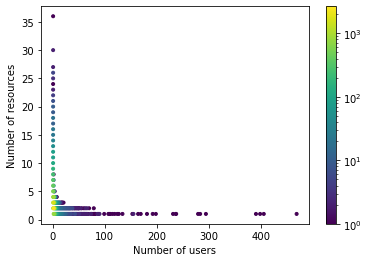

In [9]:
plot_sizes_freq(bcs,'bcs')

In [25]:
temp = []
for bc in bcs:
    if len(bc.get_usrids()) == len(bc.get_resids()):
        temp.append(bc)
x = max([len(bc.get_resids()) for bc in temp])
print('Largest symm bc:', x)

Largest symm bc: 4


**Attribute homogeneous bicliques**

In [26]:
hbcs = []
for bc in bcs:
    if bc.get_pattern() != None:
        hbcs.append(bc)

In [27]:
print('Number of maximal bicliques:', len(hbcs))
print('Number of covered edges:', get_num_covered_edges(hbcs))
print('Number of covered users:', get_num_covered_users(hbcs))
print('Number of covered resources:', get_num_covered_resources(hbcs))

Number of maximal bicliques: 12263
Number of covered edges: 26946
Number of covered users: 6001
Number of covered resources: 6839


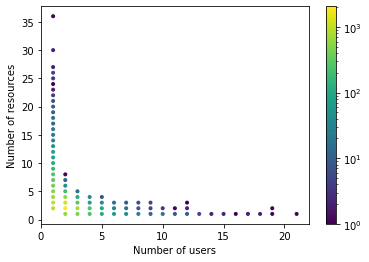

In [28]:
plot_sizes_freq(hbcs,'hbcs')